### Testando treino, teste e inferência com o SAM

In [1]:
import os
import numpy as np
import gc
from pathlib import Path

import torch
import lightning as L

# from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.data.datasets.base import SimpleDataset
from minerva.transforms.transform import _Transform
from minerva.data.readers.reader import _Reader
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import Dataset, DataLoader

from typing import List, Optional, Tuple

from matplotlib import pyplot as plt

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


#### datasets

In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# vit_b
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"
# vit_model = "vit_b"
# vit_l
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_l_0b3195.pth"
# vit_model = "vit_l"
# vit_h
checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_h_4b8939.pth"
vit_model = "vit_h"

#### Dataset (baseado no SupervisedReconstructionDataset)

In [3]:
class SupervisedDatasetPatches(SimpleDataset):
    def __init__(self, readers: List[_Reader], transforms: Optional[_Transform] = None, patch_size: int = 255, stride: int = 32):
        """Adds support for splitting images into patches.

        Parameters
        ----------
        readers: List[_Reader]
            List of data readers. It must contain exactly 2 readers.
            The first reader for the input data and the second reader for the
            target data.
        transforms: Optional[_Transform]
            Optional data transformation pipeline.
        patch_size: int
            Size of the patches into which the images will be divided.
        stride: int
            Stride used to extract patches from images.
        Raises
        -------
            AssertionError: If the number of readers is not exactly 2.
        """
        super().__init__(readers, transforms)
        self.patch_size = patch_size
        self.stride = stride
        self._patch_indices = []
        self._precompute_patch_indices()

        assert (
            len(self.readers) == 2
        ), "SupervisedReconstructionDataset requires exactly 2 readers"
    
    def _precompute_patch_indices(self):
        """Precomputes patch indices for all images."""
        for img_idx in range(len(self.readers[0])):
            # Obtem a dimensão da imagem para calcular o número de patches
            image = self.readers[0][img_idx]
            h, w = image.shape[:2]
            num_patches_h = (h - self.patch_size) // self.stride + 1
            num_patches_w = (w - self.patch_size) // self.stride + 1
            for patch_idx in range(num_patches_h * num_patches_w):
                self._patch_indices.append((img_idx, patch_idx))
    
    def _extract_single_patch(self, data, patch_idx, patch_size=255, stride=32, img_type='image'):
        if img_type == 'image': # caso seja imagens de entrada (h, w, c)
            h, w, _ = data.shape
        else: # caso seja labels de entrada (h, w)
            h, w = data.shape
        num_patches_w = (w - patch_size) // stride + 1
        row = patch_idx // num_patches_w # numero da linha do patch
        col = patch_idx % num_patches_w # numero da coluna do patch
        i, j = row * stride, col * stride # coordenada do patch no grid
        patch = data[i:i + patch_size, j:j + patch_size]
        if img_type == 'image':
            return patch.transpose(2, 0, 1).astype(np.float32) # (C H W)
        else:
            return patch.astype(np.int64)
    
    def __len__(self):
        """Returns the total number of patches."""
        return len(self._patch_indices)
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """Load data and return a single patch."""
        img_idx, patch_idx = self._patch_indices[index]
        input_data = self.readers[0][img_idx]
        target_data = self.readers[1][img_idx]

        input_patch = self._extract_single_patch(input_data, patch_idx, img_type='image')
        target_patch = self._extract_single_patch(target_data, patch_idx, img_type='label')
        return input_patch, target_patch

#### Module

In [4]:
class PatchingModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        patch_size: int = 255,
        stride: int = 32,
        batch_size: int = 8,
        transforms: _Transform = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.num_workers = num_workers if num_workers else os.cpu_count()

        self.datasets = {}

    # função útil
    def normalize_data(self, data, target_min=-1, target_max=1):
        """Function responsible for normalizing images in the range (-1,1)

        Parameters
        ----------
        data : np.ndarray
            Sample (image), with 3 channels
        target_min : int
            Min value of target to normalize data.
        target_max : int
            Max value of target to normalize data.

        Returns
        -------
        np.ndarray
            Sample (image) normalized.
        """
        data_min, data_max = data.min(), data.max()
        return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)
    
    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "train")] # lendo imagens e normalizando
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # Criar dataset para treinamento
            self.datasets['train'] = SupervisedDatasetPatches(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
                patch_size=self.patch_size,
                stride=self.stride
            )
            del train_img_reader, train_label_reader
            gc.collect()

            val_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "val")]
            val_label_reader = PNGReader(self.annotations_path / "val")

            self.datasets["val"] = SupervisedDatasetPatches(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
                patch_size=self.patch_size,
                stride=self.stride
            )
            del val_img_reader, val_label_reader
            gc.collect()
        
        elif stage == "test" or stage == "predict":
            test_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "test")]
            test_label_reader = PNGReader(self.annotations_path / "test")

            test_dataset = SupervisedDatasetPatches(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
                patch_size=self.patch_size,
                stride=self.stride
            )
            del test_img_reader, test_label_reader
            gc.collect()

            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

#### teste

In [ ]:
# model = SAMLoRA(
#     image_size=255,
#     num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
#     # pixel_mean=[123.675, 116.28],
#     # pixel_std=[58.395, 57.12],
#     alpha=1,
#     rank=4,
#     # apply_lora_vision_encoder=apply_lora_vision_encoder,
#     # apply_lora_mask_decoder=apply_lora_mask_decoder,
#     # frozen_vision_encoder=frozen_vision_encoder,
#     # frozen_prompt_encoder=frozen_prompt_encoder,
#     # frozen_mask_decoder=frozen_mask_decoder,
#     vit_model=vit_model,
#     checkpoint=checkpoint_path,
#     # train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
#     # val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
#     # test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
# )

Focal loss alpha=0.25, will shrink the impact in background


/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

In [ ]:
# data_module = PatchingModule(
#     train_path=train_path,
#     annotations_path=annotation_path,
#     patch_size=255,
#     stride=32,
#     batch_size=1
# )

# # Configura o DataModule para o estágio de treinamento
# data_module.setup(stage='fit')

# # Obtenha o DataLoader para os dados de treinamento
# train_loader = data_module.train_dataloader()

In [ ]:
# print(len(train_loader))
# for batch in train_loader:
#     image, label = batch
#     print(image.shape, label.shape)

#     num_elements = image.numel()
#     element_size = image.element_size()
#     weight_in_bytes = num_elements * element_size
#     weight_in_mb = weight_in_bytes / (1024 ** 2)
#     print(f"Tamanho de image: {image.shape}")
#     print(f"Peso em MB de uma amostra do batch: {weight_in_mb:.2f} MB")
#     break

8209
torch.Size([1, 3, 255, 255]) torch.Size([1, 255, 255])
Tamanho de image: torch.Size([1, 3, 255, 255])
Peso em MB de uma amostra do batch: 0.74 MB


In [1]:
# # Define o número de amostras que queremos exibir
# num_amostras = 6
# amostras = []

# # Itera pelos batches para coletar as amostras
# print(len(train_loader))
# for batch in train_loader:
#     image, label = batch
#     print(image.shape, label.shape)
#     image_np = image.permute(0, 2, 3, 1).detach().cpu().numpy()  # Ajusta para HWC (batch, height, width, channels)
#     label_np = label.detach().cpu().numpy()  # Sem permutação, pois já está em formato HW

#     # Normaliza a imagem se necessário
#     if image_np.max() > 1:
#         image_np = image_np / 255.0

#     # Adiciona cada imagem e rótulo ao conjunto de amostras até atingir o número desejado
#     for i in range(image_np.shape[0]):
#         amostras.append((image_np[i], label_np[i]))
#         if len(amostras) >= num_amostras:
#             break
#     if len(amostras) >= num_amostras:
#         break

# # Plota as 6 amostras em uma grade 3x2
# for idx, (img, lbl) in enumerate(amostras):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     # Plota a imagem
#     print("niveis unicos: ", np.unique(img))
#     axs[0].imshow(img)
#     axs[0].set_title("Imagem")
#     axs[0].axis('off')

#     # Plota o rótulo
#     print("niveis unicos: ", np.unique(lbl))
#     axs[1].imshow(lbl, cmap='gray')
#     axs[1].set_title("Rótulo")
#     axs[1].axis('off')

#     plt.show()

#### data module

In [5]:
data_module = PatchingModule(
    train_path=train_path,
    annotations_path=annotation_path,
    patch_size=255,
    stride=32,
    batch_size=8
)

#### modelo

In [6]:
model = SAMLoRA(
    image_size=255,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    # pixel_mean=[123.675, 116.28],
    # pixel_std=[58.395, 57.12],
    alpha=1,
    rank=4,
    # apply_lora_vision_encoder=apply_lora_vision_encoder,
    # apply_lora_mask_decoder=apply_lora_mask_decoder,
    # frozen_vision_encoder=frozen_vision_encoder,
    # frozen_prompt_encoder=frozen_prompt_encoder,
    # frozen_mask_decoder=frozen_mask_decoder,
    vit_model=vit_model,
    checkpoint=checkpoint_path,
    # train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

Focal loss alpha=0.25, will shrink the impact in background


/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

#### treino

In [7]:
from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime

current_date = datetime.now().strftime("%Y-%m-%d")

# Define o callback para salvar o modelo com base no menor valor da métrica de validação
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # Métrica para monitorar
    dirpath="./checkpoints", # Diretório onde os checkpoints serão salvos
    filename=f"2-sam-model-{current_date}-{{epoch:02d}}-{{val_loss:.2f}}", # Nome do arquivo do checkpoint
    save_top_k=1, # Quantos melhores checkpoints salvar (no caso, o melhor)
    mode="min", # Como a métrica deve ser tratada (no caso, 'min' significa que menor valor de val_loss é melhor)
)

from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="sam_model")

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | ce_loss    | CrossEntropyLoss | 0      | train
1 | dice_loss  | DiceLoss         | 0      | train
2 | focal_loss | Focal_loss       | 0      | train
3 | model      | Sam              | 637 M  | train
--------------------------------------------------------
794 K     Trainable params
636 M     Non-trainable params
637 M     Total params
2,548.592 Total estimated model params size (MB)
571       Modules in train mode
0         Modules in eval mode


Epoch 1:  19%|█▉        | 196/1026 [00:59<04:11,  3.30it/s, v_num=0, train_loss_step=0.0494, val_loss_step=0.155, val_pixel_accuracy=0.972, val_mean_class_accuracy=0.960, val_dice_score=0.972, val_mIoU=0.908, val_loss_epoch=0.161, train_pixel_accuracy=0.928, train_mean_class_accuracy=0.836, train_dice_score=0.928, train_mIoU=0.734, train_loss_epoch=0.135] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# !tensorboard --logdir logs/

#### teste

In [8]:
# trainer.test(model, data_module)
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_score      │    0.9125077128410339     │
│      test_loss_epoch      │    0.3411167860031128     │
│         test_mIoU         │    0.7201482653617859     │
│ test_mean_class_accuracy  │    0.8384112119674683     │
│    test_pixel_accuracy    │    0.9125077128410339     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_0/run_2024-11-26-22-59-3873c55728d61c4bd8adc839403f052439.yaml


[{'test_pixel_accuracy': 0.9125077128410339,
  'test_mean_class_accuracy': 0.8384112119674683,
  'test_dice_score': 0.9125077128410339,
  'test_mIoU': 0.7201482653617859,
  'test_loss_epoch': 0.3411167860031128}]

#### inferencia

In [9]:
# preds = trainer.predict(model, data_module)
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_0/run_2024-11-26-22-59-3873c55728d61c4bd8adc839403f052439.yaml


In [10]:
image = torch.argmax(preds[108]['masks'], dim=1)

In [11]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

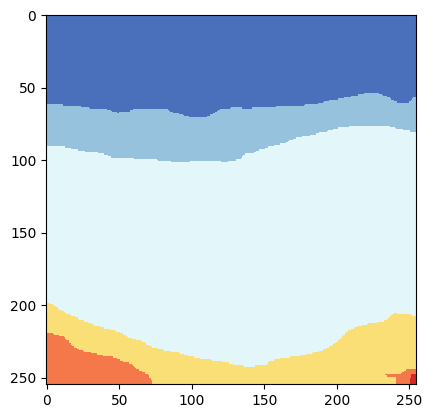

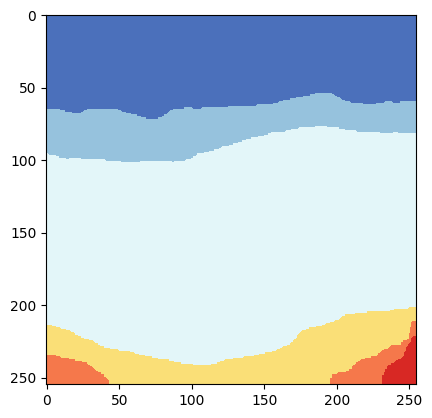

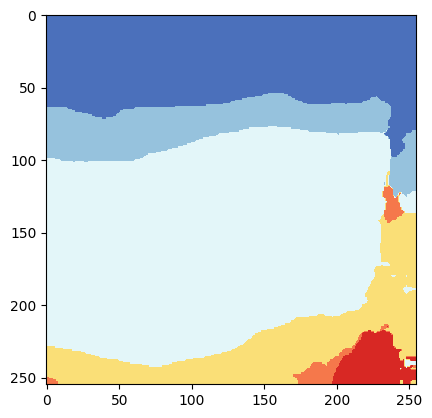

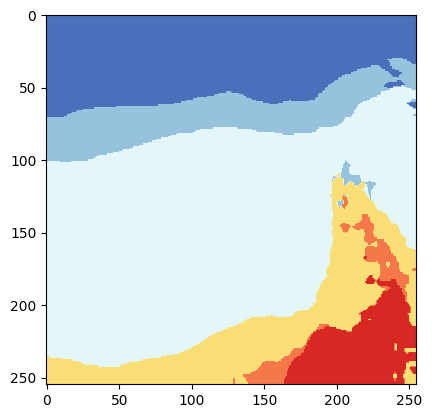

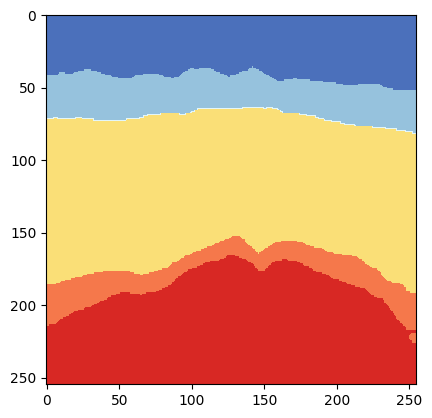

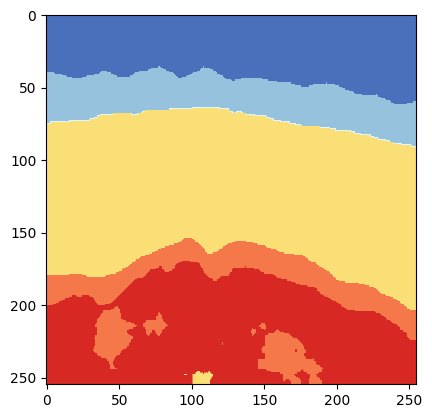

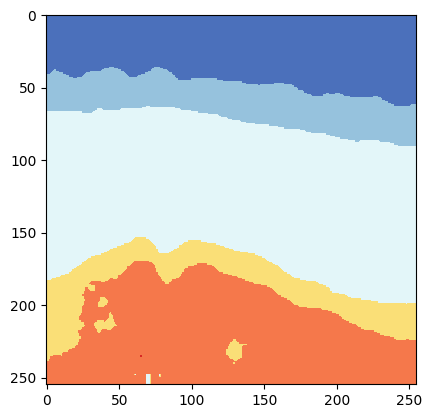

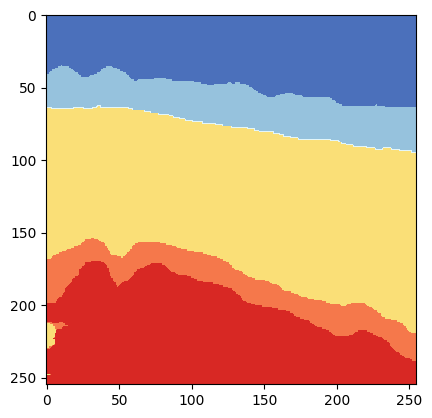

In [16]:
for img in image:
    plt.imshow(img.squeeze().numpy(), cmap=label_cmap)
    plt.show()